In [1]:
#!pip install imageio-ffmpeg

In [34]:
from skimage import img_as_float
from imageio import get_reader, get_writer
import skimage.transform as sktransform
from numpy import asarray, array
from numpy.linalg import inv
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import cv2


from mpl_point_clicker import clicker

from IPython.display import display, Image
import ipywidgets as widgets
import threading


In [35]:
#convert RBG to YIQ
def rgb2ntsc(src):
    [rows,cols]=src.shape[:2]
    dst=np.zeros((rows,cols,3),dtype=np.float64)
    T = np.array([[0.114, 0.587, 0.298], [-0.321, -0.275, 0.596], [0.311, -0.528, 0.212]])
    for i in range(rows):
        for j in range(cols):
            dst[i, j]=np.dot(T,src[i,j])
    return dst

#convert YIQ to RBG
def ntsc2rbg(src):
    [rows, cols] = src.shape[:2]
    dst=np.zeros((rows,cols,3),dtype=np.float64)
    T = np.array([[1, -1.108, 1.705], [1, -0.272, -0.647], [1, 0.956, 0.620]])
    for i in range(rows):
        for j in range(cols):
            dst[i, j]=np.dot(T,src[i,j])
    return dst



In [36]:

def load_video(filename):
    reader = get_reader(filename)
    orig_vid = []
    for i, im in enumerate(reader):
        orig_vid.append(im)
    return asarray(orig_vid)

def write_video(video, fps, name):
    writer = get_writer(name, fps=fps)
    for i in range(video.shape[0]):
        writer.append_data(video[i])
    writer.close()


In [37]:
#Build Gaussian Pyramid
def build_gaussian_pyramid(src,level=3):
    s=src.copy()
    pyramid=[s]
    for i in range(level):
        s=cv2.pyrDown(s)
        pyramid.append(s)
    return pyramid

In [38]:
#Build Laplacian Pyramid
def build_laplacian_pyramid(src,levels=3):
    
    pyramid=[]
    gaussianPyramid = build_gaussian_pyramid(src, levels)
        
    for i in range(levels,0,-1):
        GE=cv2.pyrUp(gaussianPyramid[i])
        L=cv2.subtract(gaussianPyramid[i-1],GE)
        pyramid.append(L)
    return pyramid



In [39]:
# Show users the frame and ask them to choose ROI
def ROI_choice(video):
    # display a frame of the video, ask user to input ROI by mouse click
    # return the yiq version of the ROI
    pass

In [40]:
video_file = "after.mp4"

In [41]:
video = load_video(video_file)
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')


In [42]:
num_frames, h, w, num_channels = video.shape
#num_frames = 500

In [43]:
num_frames

288

In [46]:
ystart = int(klicker.get_positions()["event"][0][1])
yend = int(klicker.get_positions()["event"][2][1])
xstart = int(klicker.get_positions()["event"][0][0])
xend=int(klicker.get_positions()["event"][1][0])

h_crop = yend-ystart
w_crop = xend-xstart

#convert video to yiq
video_yiq = np.zeros((num_frames,h_crop,w_crop,num_channels))

for frame in range(num_frames):
    video_yiq[frame] = rgb2ntsc(video[frame][ystart:yend,xstart:xend])
    

In [47]:
#Construct gaussian levels
pyramid=[]
levels = 3
l0 = []
l1 =[]
l2=[]
l3=[]
for frames in range(num_frames):
    
    gaussianPyramid = build_gaussian_pyramid(video_yiq[frames], levels)
    
    l0.append(video[frames][ystart:yend,xstart:xend])
    l1.append(gaussianPyramid[0])
    l2.append(gaussianPyramid[1])
    l3.append(gaussianPyramid[2])


In [48]:
# l1 is the original in ntsc color scheme
# l0 is the original in rgb color scheme
l1[0].shape

(127, 328, 3)

In [49]:
px_0 = np.zeros(num_frames)
px_1 = np.zeros(num_frames)
px_2 =np.zeros(num_frames)
px_3 =np.zeros(num_frames)


for frame in range(num_frames):
    
    px_0[frame] = np.average(l0[frame])
    px_1[frame] = np.average(l1[frame])
    px_2[frame] = np.average(l2[frame])
    px_3[frame] = np.average(l3[frame])
    
    
    #px_R[frame] = video[frame][600:601,450:451][0][0][0]
   # px_G[frame] = video[frame][600:601,450:451][0][0][1]
    #px_B[frame] = video[frame][600:601,450:451][0][0][2]
    

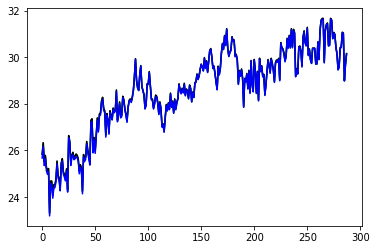

In [50]:
%matplotlib inline
plt.plot(px_1,'g')
plt.plot(px_2,'k')
plt.plot(px_3,'b')


# Detrend and normalize

In [51]:
import scipy

In [52]:
from scipy import sparse

def advance_detrend(signal, lam = 10):
    T = len(signal)
    I  = np.identity(T)

    filt = [1,-2,1]* np.ones((1,T-2),dtype=np.int).T
    D2 = sparse.spdiags(filt.T, (range(0,3)),T-2,T)

    # detrend_sig = (I - np.linalg.inv(I + lam**2*D2.T*D2))@signal
    trend = (np.linalg.inv(I + lam**2*D2.T*D2))@signal
    detrend_sig = np.squeeze(np.array(signal - trend))
    trend = np.squeeze(np.array(trend))
    return detrend_sig, trend

In [53]:
# normalization section
def normalizeToUnitVariance(sig):
    normalized = (sig - np.mean(sig))/np.std(sig)
    return normalized

In [54]:
sig,trend = advance_detrend(px_1)


C:\Users\Smart\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


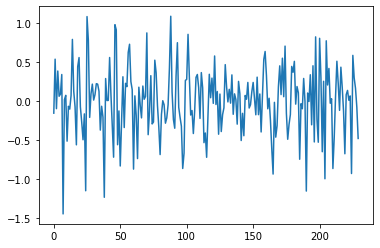

In [55]:
truncated_sig = sig[:int(0.8*len(sig))] #take 80% of the data
plt.plot(truncated_sig) 

# Convert pixel data to pandas dataframe

In [56]:
import pandas as pd

In [57]:

df1 = pd.DataFrame(truncated_sig,columns=['orig'])

In [58]:
df1

,orig
0,-0.153760
1,0.538295
2,-0.096141
3,0.386423
4,0.062956
...,...
225,0.587053
226,0.299325
227,0.166123
228,-0.077864


In [59]:
df1.to_pickle("after.pkl")